**Names of all group members**:

Amalie Riff Brems

Peter Lund Andersen

All of the following was implemented using Python 3.11.5

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Fix random generation seed for reproducibility
np.random.seed(201223)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Exercise 1 (Poisson GLM)

### Question 1.a

In [274]:
# Read the data from the csv file 'freMTPL2freq.csv'
df = pd.read_csv("freMTPL2freq.csv",sep = ";", decimal= ",")
# Pre-process the data as instructed
#Transformation of variables and removal of PolicyID
df["TrunVehPower"]  = df["VehPower"].transform(lambda x: min(x, 9))
df["BinsVehAge"] = pd.cut(x = df["VehAge"], bins = [0, 6, 13, float("inf")], right = False)
df["LogDrivAge"] = df["DrivAge"].transform("log")
df["TrunBonusMalus"]  = df["BonusMalus"].transform(lambda x: min(x, 150.0))
df["LogTrunBonusMalus"]  = df["TrunBonusMalus"].transform("log")
df["LogDensity"] = df["Density"].transform("log")
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df = df.drop("PolicyID", axis = 1)

### Standardize

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehPower           678007 non-null  int64   
 1   VehAge             678007 non-null  int64   
 2   DrivAge            678007 non-null  int64   
 3   BonusMalus         678007 non-null  int64   
 4   VehBrand           678007 non-null  object  
 5   VehGas             678007 non-null  object  
 6   Density            678007 non-null  int64   
 7   Region             678007 non-null  object  
 8   Exposure           678007 non-null  float64 
 9   ClaimNb            678007 non-null  int64   
 10  TrunVehPower       678007 non-null  int64   
 11  BinsVehAge         678007 non-null  category
 12  LogDrivAge         678007 non-null  float64 
 13  TrunBonusMalus     678007 non-null  float64 
 14  LogTrunBonusMalus  678007 non-null  float64 
 15  LogDensity         678007 non-null

We now take the needed variables for 1a and do hot-encoding for the catagorical factors and standardization for the continous ones. 

In [276]:
continuous_features = ["LogDrivAge", "LogTrunBonusMalus", "LogDensity"]
df_continuous = df[continuous_features]
# Standardize all continuous features
df_continuous = df_continuous.subtract(df_continuous.mean()).divide(df_continuous.std())

categorical_features = ["TrunVehPower", "BinsVehAge", "Region", "VehBrand", "VehGas"]
df_categorical = df[categorical_features].astype(dtype="category")
df_categorical =pd.get_dummies(df_categorical, dtype = int)

df_features = pd.concat([df_continuous, df_categorical], axis = 1)
labels = ["Frequency", "Exposure"]
df_labels = df[labels]

### Question 1.b

We here fit with "alpha = 0.0" for the PoissonRegressor since we want to fit a unpenalized GLM in terms of L2.

In [277]:
# Perform train-test split 
X_data = df_features
y_data = df_labels

# We use the sklean.preprocessing spliting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=12345)

# Fit a Poisson GLM
from sklearn.linear_model import PoissonRegressor
glm1 = PoissonRegressor(alpha = 0.0)
glm1.fit(X = X_train, y = y_train["Frequency"], sample_weight = y_train["Exposure"])

# Report metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance
y_predict_train = glm1.predict(X_train)
MAE_train = mean_absolute_error(y_true=  y_train["Frequency"], y_pred= y_predict_train, sample_weight= y_train["Exposure"])
MSE_train = mean_squared_error(y_true= y_train["Frequency"],y_pred= y_predict_train,  sample_weight= y_train["Exposure"])
MPD_train = mean_poisson_deviance(y_true= y_train["Frequency"], y_pred= y_predict_train, sample_weight= y_train["Exposure"])

y_predict_test = glm1.predict(X_test)
MAE_test = mean_absolute_error(y_pred= y_predict_test, y_true= y_test["Frequency"], sample_weight= y_test["Exposure"])
MSE_test = mean_squared_error(y_pred= y_predict_test, y_true= y_test["Frequency"], sample_weight= y_test["Exposure"])
MPD_test = mean_poisson_deviance(y_pred= y_predict_test, y_true= y_test["Frequency"], sample_weight= y_test["Exposure"])

In [278]:
print('Mean Absolute Error for training data: ', MAE_train)
print('Mean Squared Error for training data: ', MSE_train)
print('Mean Poisson Deviance for training data: ', MPD_train)
print('Mean Absolute Error for test data: ', MAE_test)
print('Mean Squared Error for test data: ', MSE_test)
print('Mean Poisson Deviance for test data: ', MPD_test)

Mean Absolute Error for training data:  0.13773642381911833
Mean Squared Error for training data:  0.2380153477181417
Mean Poisson Deviance for training data:  0.45697174274322105
Mean Absolute Error for test data:  0.13806111365565785
Mean Squared Error for test data:  0.2294345810308002
Mean Poisson Deviance for test data:  0.45625824787374525


### Question 1.c

We start by constructing the new variables and the follow the workflow from before.

In [279]:
df["SqrDrivAge"]  = df["VehAge"] * df["VehAge"]
df["BonusMalus*DrivAge"] = df["BonusMalus"]*df["DrivAge"]
df["BonusMalus*SqrDrivAge"] = df["BonusMalus"]*df["SqrDrivAge"]

In [280]:
continuous_features = ["LogDrivAge", "LogTrunBonusMalus", "LogDensity", "DrivAge", "SqrDrivAge", "BonusMalus*DrivAge", "BonusMalus*SqrDrivAge"]
df_continuous = df[continuous_features]
df_continuous = df_continuous.subtract(df_continuous.mean()).divide(df_continuous.std())

# We still use the same categorical variables, so we dont need to change that data frame. 
df_features = pd.concat([df_continuous, df_categorical], axis = 1)

We here again fit with "alpha = 0.0" for the PoissonRegressor since we want to fit a unpenalized GLM in terms of L2.

In [281]:
# Augment data with new engineered features
X_data = df_features
y_data = df_labels

# We use the sklean.preprocessing spliting (since we can get the same split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=12345)
# Fit a Poisson GLM
from sklearn.linear_model import PoissonRegressor
glm2 = PoissonRegressor(alpha = 0.0)
glm2.fit(X = X_train, y = y_train["Frequency"], sample_weight = y_train["Exposure"])

# Report metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance
y_predict_train = glm2.predict(X_train)
MAE_train = mean_absolute_error(y_true= y_train["Frequency"], y_pred= y_predict_train, sample_weight= y_train["Exposure"])
MSE_train = mean_squared_error(y_true= y_train["Frequency"], y_pred= y_predict_train, sample_weight= y_train["Exposure"])
MPD_train = mean_poisson_deviance(y_true= y_train["Frequency"], y_pred= y_predict_train,sample_weight= y_train["Exposure"])


y_predict_test = glm2.predict(X_test)
MAE_test = mean_absolute_error(y_true= y_test["Frequency"], y_pred= y_predict_test, sample_weight= y_test["Exposure"])
MSE_test = mean_squared_error(y_true= y_test["Frequency"], y_pred= y_predict_test, sample_weight= y_test["Exposure"])
MPD_test = mean_poisson_deviance(y_true= y_test["Frequency"], y_pred= y_predict_test, sample_weight= y_test["Exposure"])

In [282]:
# Training error
print('Mean Absolute Error for training data: ', MAE_train)
print('Mean Squared Error for training data: ', MSE_train)
print('Mean Poisson Deviance for training data: ', MPD_train)

# Test error
print('Mean Absolute Error for test data: ', MAE_test)
print('Mean Squared Error for test data: ', MSE_test)
print('Mean Poisson Deviance for test data: ', MPD_test)

Mean Absolute Error for training data:  0.13783200364520568
Mean Squared Error for training data:  0.23799362664531223
Mean Poisson Deviance for training data:  0.45653517735776394
Mean Absolute Error for test data:  0.13813144145573447
Mean Squared Error for test data:  0.22933939441458243
Mean Poisson Deviance for test data:  0.45567344957400907


We see that the model performs better, with a lower score in both training and test data. Especially the Mean Poisson Deviance scores are lower. We go from 0.4570 to 0.4565 for the training data and from   0.4563 to 0.4556 for the Mean Poisson Deviance on the test data.

We here note that with our training-test split it seems in general for this assignemnt, that the error, especially Mean Poisson Deviance is lower for the test data. 

In [283]:
# Why is the model performance better?

We see that the models performs, better. 

Since we have a more complex model, it would make sense that we perform better on the training data. We also see that we perform, better on the test data. This indicats that there is notiable change in information when we include the raw 'DrivAge', 'DrivAge**2' and their interaction with 'BonusMalus'. 

If one was to speculate, we would have that since 'BonusMalus' starts at 100 then if we know that people are young then, since they havent have alot of time to get into an accideint, it might be high. Whereas as middel aged person with a high 'BonusMalus' might indicate a better driver. Lastly we might want something non-linear in 'DrivAge' also, since we don't observe that accidents keep decreasing with age. 

In [284]:
# Conduct a small data analysis to show how claim frequencies
# vary as function of DrivAge

We group into different age brarkes and group over them to get a view of it

<Axes: ylabel='Frequency'>

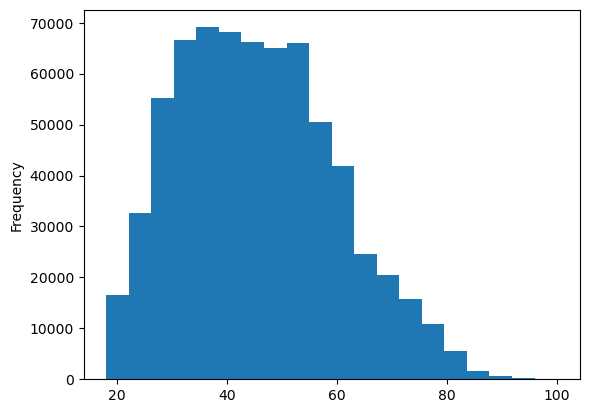

In [285]:
df["DrivAge"].plot.hist(bins = 20)

In [286]:
df["DrivAge"].min()

18

We get the minimun to 18 in order to set the brackets.

In [287]:
df["BinsDrivAge"] = pd.cut(x = df["DrivAge"], bins = [18., 20., 25., 30., 40., 50., 60., 70., 80., float("inf")], right = False)

<Axes: xlabel='BinsDrivAge'>

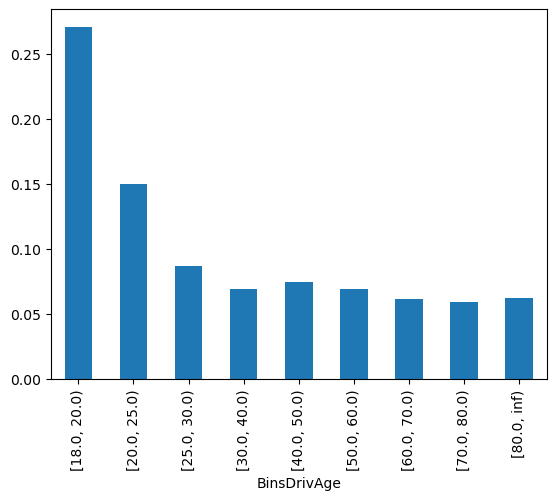

In [288]:
estimate_freq_BinsDrivAge = df.groupby("BinsDrivAge")["ClaimNb"].sum() / df.groupby("BinsDrivAge")["Exposure"].sum()
estimate_freq_BinsDrivAge.plot.bar()

We here clearly see that as the age increases, the frequency drops, but after aobut age 30 it levels off. 

We now look at the "BonusMalus".

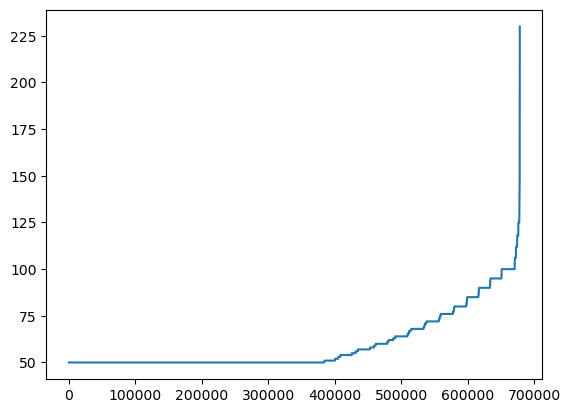

In [289]:
plt.plot(np.sort(df["BonusMalus"]))

We see that alot have a value fo 50 and the stepwise untill we reaches the large ones, where we have a few. Giving us the following bins. 

In [290]:
df["BinsBonusMalus"] = pd.cut(x = df["BonusMalus"], bins = [50, 60, 80, 100, 110, 150, float("inf")], right = False)

<Axes: xlabel='BinsBonusMalus'>

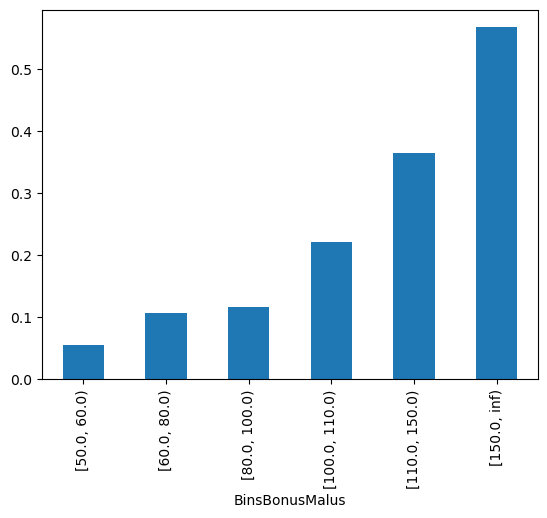

In [291]:
estimate_freq_BinsBonusMalus = df.groupby("BinsBonusMalus")["ClaimNb"].sum() / df.groupby("BinsBonusMalus")["Exposure"].sum()
estimate_freq_BinsBonusMalus.plot.bar()

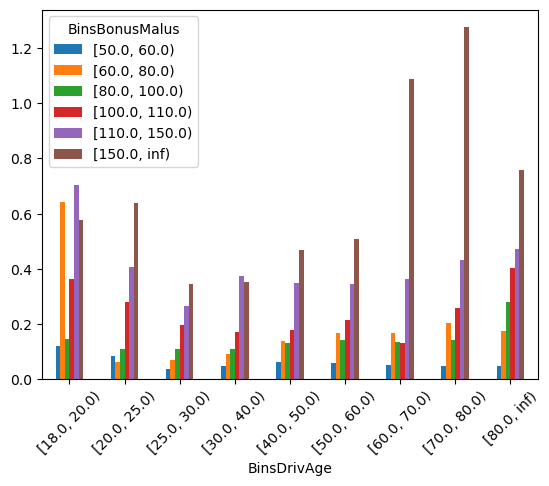

In [292]:
DaBmCla = df.groupby(["BinsDrivAge", "BinsBonusMalus"])["ClaimNb"].sum()
DaBmExp = df.groupby(["BinsDrivAge", "BinsBonusMalus"])["Exposure"].sum()
DaBmFrq = DaBmCla/DaBmExp

fig, ax = plt.subplots()
DaBmFrq.unstack().plot(kind='bar', ax=ax)
plt.xticks(rotation=45)
plt.show()

We here see the emperical frequency for each group of Driver Age, and the BonusMalus for each. We here clearly see that it mostly increasing for each age-group, but note some wild behave for the ones in age 18 to 20. It therefore makes sense that our model can use a interaction between the 'DrivAge' and 'BonusMalus' for the fitting of the data. 

# Exercise 2 (Neural network)

### Question 2.a

In [293]:
from keras.models import Sequential
from keras.layers import Input, Dense, Concatenate, Subtract, Multiply, Lambda, Add, BatchNormalization
from keras.backend import constant
from keras import optimizers
import tensorflow as tf

#from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import regularizers
import keras.backend as K

We implement the following model, using the Poisson deviance loss, we got as help. (We need to implement at start because of our type of neural network we are using in Keras).

In [294]:
def poisson_deviance_loss(y_true, l_pred):

        log_y_true = K.switch(K.equal(y_true, 0), K.zeros_like(y_true), K.log(y_true))

        log_l_pred = K.switch(K.equal(l_pred, 0), K.zeros_like(l_pred), K.log(l_pred))

        loss = 2 * (l_pred - y_true - y_true * log_l_pred + y_true * log_y_true)

        return loss


def custom_loss(y_true, y_pred, weights):
    loss = poisson_deviance_loss(y_true, y_pred)
    return(  tf.divide(K.mean(weights * loss), K.mean(weights)))

We implement a neural network with 2 hidden layers and 32 neurons in each hidden layer. We use a special version of the functional API, to get faster loss functions, so we don't have to split the data during the traning. We have ended up with the following network below, also using Batch Normalization and regulazation. 

In [295]:
np.random.seed(201223)

n_hidden_nodes = 32
hidden_layers = 3

X_input = Input((47,))
y_true = Input((1,))
weights = Input((1,))

layer = X_input
for _ in range(hidden_layers):
    layer = Dense(n_hidden_nodes, activation='tanh', kernel_initializer='glorot_normal', bias_initializer='zeros',
        kernel_regularizer = regularizers.L1L2(l1 = 0.0001, l2 = 0.0001),
                      activity_regularizer = regularizers.L2 (0.0001))(layer)
    layer = BatchNormalization()(layer)
    
output = Dense(1, activation= "exponential",kernel_initializer='glorot_normal', bias_initializer='zeros',
                kernel_regularizer = regularizers.L1L2(l1 = 0.01, l2 = 0.01),
                      activity_regularizer = regularizers.L2 (0.01))(layer)

model = Model([X_input ,y_true ,weights], output)
model.add_loss(custom_loss(y_true, output, weights))

### Question 2.b

We import the data from 1.a and traing the neural network. We note that we throughout use the same train_test split, so we can compare the results. 

In [296]:
continuous_features = ["LogDrivAge", "LogTrunBonusMalus", "LogDensity"]
df_continuous = df[continuous_features]
df_continuous = df_continuous.subtract(df_continuous.mean()).divide(df_continuous.std())

categorical_features = ["TrunVehPower", "BinsVehAge", "Region", "VehBrand", "VehGas"]
df_categorical = df[categorical_features].astype(dtype="category")
df_categorical =pd.get_dummies(df_categorical)

df_features = pd.concat([df_continuous, df_categorical], axis = 1)
labels = ["Frequency", "Exposure"]
df_labels = df[labels]

# Augment data with new engineered features
X_data = np.array(df_features).astype("float32") #convert 0-1 to float for 
y_data = np.array(df_labels)

# We use the sklean.preprocessing spliting (since we can get the same split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=12345)

We end up using a Exponential Decay scheduler and optimize with Adam and run for 100 epochs with a batch size of 3100.

In [297]:
from keras.optimizers.schedules.learning_rate_schedule import ExponentialDecay 
lr_schedule =ExponentialDecay(0.01, decay_steps = 1000, decay_rate=0.9)
optimizer = optimizers.Adam(learning_rate= lr_schedule)

model.compile(loss=None, optimizer= optimizer)
history = model.fit(x = [X_train, y_train[:, 0], y_train[:, 1]], y = None, verbose = 0,  epochs = 100, batch_size= 3100, 
                    validation_data = ([X_test, y_test[:, 0], y_test[:, 1]], None))
# We can add the trained parameters to a new neural network without the loss implementation, so this is a standard Keras network. 
fitted_model = Model(X_input, output)

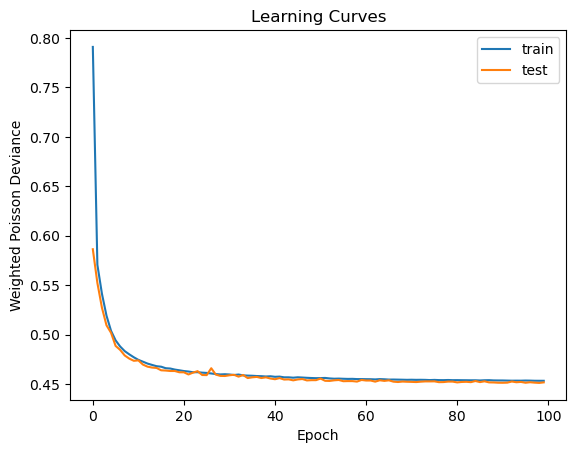

In [298]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Weighted Poisson Deviance')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

We here see good convergence with the training and test loss. 

In [299]:
# Loss on training data
y_predict_train = fitted_model.predict(X_train)
MAE_train = mean_absolute_error(y_true= y_train[:, 0], y_pred= y_predict_train, sample_weight= y_train[:, 1])
MSE_train = mean_squared_error(y_true= y_train[:, 0], y_pred= y_predict_train, sample_weight=  y_train[:, 1])
MPD_train = mean_poisson_deviance(y_true= y_train[:, 0], y_pred= y_predict_train,sample_weight=  y_train[:, 1])

# Loss on test data
y_predict_test = fitted_model.predict(X_test)
MAE_test = mean_absolute_error(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])
MSE_test = mean_squared_error(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])
MPD_test = mean_poisson_deviance(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])

2119/2119 [==============================] - 1s 262us/step


In [300]:
# Report metrics
print('Mean Absolute Error for training data: ', MAE_train)
print('Mean Squared Error for training data: ', MSE_train)
print('Mean Poisson Deviance for training data: ', MPD_train)

print('Mean Absolute Error for test data: ', MAE_test)
print('Mean Squared Error for test data: ', MSE_test)
print('Mean Poisson Deviance for test data: ', MPD_test)

Mean Absolute Error for training data:  0.1343702519542929
Mean Squared Error for training data:  0.23715903919014544
Mean Poisson Deviance for training data:  0.4501061605581584
Mean Absolute Error for test data:  0.1344909993646082
Mean Squared Error for test data:  0.22852509534088822
Mean Poisson Deviance for test data:  0.4489337497660703


We here get a little bit lower value, esepcially for the Mean Poisson Deviance loss, with this neural network compared to the GLM. 

# Exercise 3 (Tree-based methods)

### Question 3.a

We use the sklearn 'KFold' to split the training data into 5 cross validation parts and use in all the cross validations for the rest of the assignment. 

In [301]:
continuous_features = ["LogDrivAge", "LogTrunBonusMalus", "LogDensity"]
df_continuous = df[continuous_features]
df_continuous = df_continuous.subtract(df_continuous.mean()).divide(df_continuous.std())

categorical_features = ["TrunVehPower", "BinsVehAge", "Region", "VehBrand", "VehGas"]
df_categorical = df[categorical_features].astype(dtype="category")
df_categorical =pd.get_dummies(df_categorical)

df_features = pd.concat([df_continuous, df_categorical], axis = 1)
labels = ["Frequency", "Exposure"]
df_labels = df[labels]

# Augment data with new engineered features
X_data = df_features.values
y_data = df_labels.values

# We use the sklean.preprocessing spliting (since we can get the same split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=12345)

# Cross-validation, we note that we use the same cross validation set for all the methods.
from sklearn.model_selection import KFold
K_fold = 5
kf = KFold(n_splits = K_fold, random_state= 12345, shuffle= True)
kf.get_n_splits()


5

We implement 'DecisionTreeRegressor' with criterion= "poisson" for fitting and letting the min_impurity_decrease be in the following:
$$
\log_{10}(\text{min impurity decrease})  \in  \{-7, , 6,, \ldots , -1, 0\} 
$$  

We here note that the rest of the hyperparameters are left as the deafult, and also the same for the rest of the methods.

In [302]:
# Implementing 
from sklearn.tree import DecisionTreeRegressor
min_impurity_decrease_vec = 10.0**( np.arange(-7, 1, 1) )

weighted_poisson_deviance = np.zeros(len(min_impurity_decrease_vec))

for train, test in kf.split(X_train, y_train):
    X_training_data = X_train[train]
    X_test_data = X_train[test]
    
    y_training_data = y_train[train]
    y_test_data = y_train[test]
    
    for i in range(len(min_impurity_decrease_vec)):
        min_impurity_decrease = min_impurity_decrease_vec[i]
        regression_tree = DecisionTreeRegressor(criterion= "poisson", min_impurity_decrease= min_impurity_decrease)
        regression_tree.fit(X_training_data, y_training_data[:, 0], y_training_data[:, 1])
        
        y_pred = regression_tree.predict(X_test_data)
        weighted_poisson_deviance[i] += mean_poisson_deviance(y_test_data[:, 0], y_pred, sample_weight = y_test_data[:, 1]) / K_fold

We get a optimal value weighted Poisson deviance of: 0.4541169545378614
With a value of log10(min_impurity_decrease) equal to  -4.0


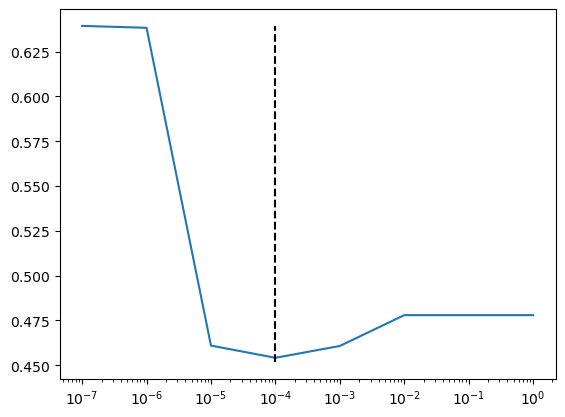

In [303]:
optimal_index = np.argmin(weighted_poisson_deviance)
plt.semilogx(min_impurity_decrease_vec, weighted_poisson_deviance, base  = 10)
plt.vlines(min_impurity_decrease_vec[optimal_index], 
           ymin = 0.995 * np.min(weighted_poisson_deviance), ymax = np.max(weighted_poisson_deviance), colors = "black", linestyles= 'dashed')
print("We get a optimal value weighted Poisson deviance of:", weighted_poisson_deviance[optimal_index])
print("With a value of log10(min_impurity_decrease) equal to ", np.log10(min_impurity_decrease_vec[optimal_index]) )

We can above see the optimal value over 'min_impurity_decrease' using the cross validation. We fit we the optimal value and report the losses below:

In [304]:
# Fitting the optimal regression tree
regression_tree = DecisionTreeRegressor( criterion= "poisson", min_impurity_decrease= min_impurity_decrease_vec[optimal_index])
regression_tree.fit(X_train, y_train[:, 0], sample_weight= y_train[:, 1])

DecisionTreeRegressor(criterion='poisson', min_impurity_decrease=0.0001)

In [305]:
# Loss on training data
y_predict_train = regression_tree.predict(X_train)
MAE_train = mean_absolute_error(y_true= y_train[:, 0], y_pred= y_predict_train, sample_weight= y_train[:, 1])
MSE_train = mean_squared_error(y_true= y_train[:, 0], y_pred= y_predict_train, sample_weight=  y_train[:, 1])
MPD_train = mean_poisson_deviance(y_true= y_train[:, 0], y_pred= y_predict_train,sample_weight=  y_train[:, 1])

# Loss on test data
y_predict_test = regression_tree.predict(X_test)
MAE_test = mean_absolute_error(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])
MSE_test = mean_squared_error(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])
MPD_test = mean_poisson_deviance(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])

In [306]:
# Report metrics
print('Mean Absolute Error for training data: ', MAE_train)
print('Mean Squared Error for training data: ', MSE_train)
print('Mean Poisson Deviance for training data: ', MPD_train)

print('Mean Absolute Error for test data: ', MAE_test)
print('Mean Squared Error for test data: ', MSE_test)
print('Mean Poisson Deviance for test data: ', MPD_test)

Mean Absolute Error for training data:  0.13688660168991412
Mean Squared Error for training data:  0.237374740296505
Mean Poisson Deviance for training data:  0.45326253071060624
Mean Absolute Error for test data:  0.13694990124136827
Mean Squared Error for test data:  0.22852361485578385
Mean Poisson Deviance for test data:  0.4517539168359575


We get a Mean Poisson Deviance lower than both GLM models, but still a bit worse than the NN. 

### Question 3.b

We now use 'RandomForestRegressor' with criterion= "poisson" and optimize over the max_features first. (We here take the min_impurity_decrease using the default of $0.0$, but could also have used the value from 3.a). 

We here look at 

$$
\text{max\_features}  \in  \{1, 2, \ldots, 9, 10\} 
$$


In [307]:
from sklearn.ensemble import RandomForestRegressor

max_features_vec = np.arange(1, 11)

weighted_poisson_deviance = np.zeros(len(max_features_vec))

for train, test in kf.split(X_train, y_train):
    X_training_data = X_train[train]
    X_test_data = X_train[test]
    
    y_training_data = y_train[train]
    y_test_data = y_train[test]
    
    for i in range(len(max_features_vec)):
        max_features = max_features_vec[i]
        regression_tree = RandomForestRegressor(criterion= "poisson", max_features = max_features, n_jobs = -1)
        regression_tree.fit(X_training_data, y_training_data[:, 0], y_training_data[:, 1])
        
        y_pred = regression_tree.predict(X_test_data)
        
        weighted_poisson_deviance[i] += mean_poisson_deviance(y_test_data[:, 0], y_pred, sample_weight = y_test_data[:, 1]) / K_fold

We get a optimal value weighted Poisson deviance of: 0.4580636090924383
With a value of 'max_features' equal to  4


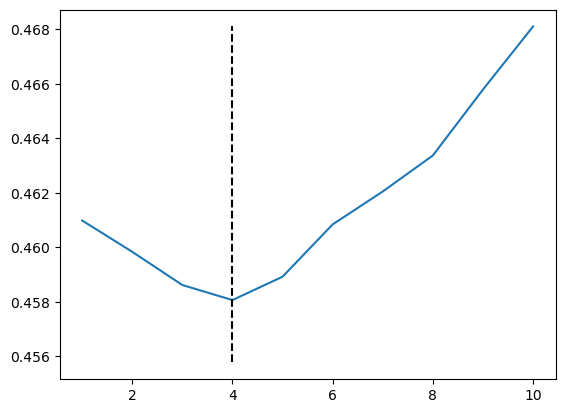

In [308]:
plt.plot(max_features_vec, weighted_poisson_deviance)
optimal_index_features = np.argmin(weighted_poisson_deviance)
print("We get a optimal value weighted Poisson deviance of:", weighted_poisson_deviance[optimal_index_features])
print("With a value of 'max_features' equal to ", max_features_vec[optimal_index_features])
plt.vlines(max_features_vec[optimal_index_features], ymin = 0.995 * np.min(weighted_poisson_deviance), ymax = np.max(weighted_poisson_deviance), colors = "black", linestyles= 'dashed')

Using the value from max_features we look at the optimal min_impurity_decrease using the same values as in 3.a
$$
\log_{10}(\text{min impurity decrease})  \in  \{-10, -9, \ldots , -1, 0\} 
$$ 

In [309]:
# We do the same for the impurity. Using the same values as before
min_impurity_decrease_vec = 10.0**( np.arange(-10, 1, 1))

weighted_poisson_deviance = np.zeros(len(min_impurity_decrease_vec))

for train, test in kf.split(X_train, y_train):
    X_training_data = X_train[train]
    X_test_data = X_train[test]
    
    y_training_data = y_train[train]
    y_test_data = y_train[test]
    
    for i in range(len(min_impurity_decrease_vec)):
        min_impurity_decrease = min_impurity_decrease_vec[i]
        regression_tree = RandomForestRegressor(criterion= "poisson", max_features = max_features_vec[optimal_index_features], 
                                                min_impurity_decrease= min_impurity_decrease, n_jobs = -1)
        regression_tree.fit(X_training_data, y_training_data[:, 0], y_training_data[:, 1])
        
        y_pred = regression_tree.predict(X_test_data)
        
        weighted_poisson_deviance[i] += mean_poisson_deviance(y_test_data[:, 0], y_pred, sample_weight = y_test_data[:, 1]) / K_fold

We get a optimal value weighted Poisson deviance of: 0.4557716337242541
With a value of log10(min_impurity_decrease) equal to  -6.0


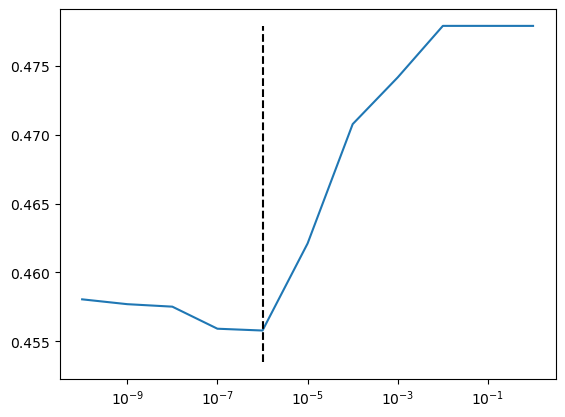

In [310]:
plt.semilogx(min_impurity_decrease_vec, weighted_poisson_deviance)
optimal_index_impurity = np.argmin(weighted_poisson_deviance)
print("We get a optimal value weighted Poisson deviance of:", weighted_poisson_deviance[optimal_index_impurity])
print("With a value of log10(min_impurity_decrease) equal to ", np.log10(min_impurity_decrease_vec[optimal_index_impurity]) )
plt.vlines(min_impurity_decrease_vec[optimal_index_impurity], ymin = 0.995 * np.min(weighted_poisson_deviance), ymax = np.max(weighted_poisson_deviance), colors = "black", linestyles= 'dashed')

We here note that this low value of 'min_impurity_decrease' might be affected by optimizing with 'min_impurity_decrease = 0.0' in the first cross validation over 'max_features'. We would also have used the value for 'minimum impurity decrease' from 3a. 

In [311]:
# Fitting the optimal random forrest
random_forrest = RandomForestRegressor( criterion= "poisson", max_features = max_features_vec[optimal_index_features], 
                                       min_impurity_decrease= min_impurity_decrease_vec[optimal_index_impurity], n_jobs = -1)
random_forrest.fit(X_train, y_train[:, 0], sample_weight= y_train[:, 1])

RandomForestRegressor(criterion='poisson', max_features=4,
                      min_impurity_decrease=1e-06, n_jobs=-1)

In [312]:
# Loss on training data
y_predict_train = random_forrest.predict(X_train)
MAE_train = mean_absolute_error(y_true= y_train[:, 0], y_pred= y_predict_train, sample_weight= y_train[:, 1])
MSE_train = mean_squared_error(y_true= y_train[:, 0], y_pred= y_predict_train, sample_weight=  y_train[:, 1])
MPD_train = mean_poisson_deviance(y_true= y_train[:, 0], y_pred= y_predict_train,sample_weight=  y_train[:, 1])

# Loss on test data
y_predict_test = random_forrest.predict(X_test)
MAE_test = mean_absolute_error(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])
MSE_test = mean_squared_error(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])
MPD_test = mean_poisson_deviance(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])


# Report metrics
print('Mean Absolute Error for training data: ', MAE_train)
print('Mean Squared Error for training data: ', MSE_train)
print('Mean Poisson Deviance for training data: ', MPD_train)

print('Mean Absolute Error for test data: ', MAE_test)
print('Mean Squared Error for test data: ', MSE_test)
print('Mean Poisson Deviance for test data: ', MPD_test)

Mean Absolute Error for training data:  0.1375164306342952
Mean Squared Error for training data:  0.23513897521424723
Mean Poisson Deviance for training data:  0.434362261417043
Mean Absolute Error for test data:  0.13898569992944418
Mean Squared Error for test data:  0.22959690240468908
Mean Poisson Deviance for test data:  0.4532323195264648


We get a Mean Poisson Deviance loss that is higher on the test data, than for the Neural Network and regression trees. This seems because we have overfitted on the training data, even though this should have been voided with the cross validation. 

### Question 3.c

We optimize over the shrinkage parameter and the number of boosting steps. We start with shrinkage parameter, here called 'learning_rate'. For the rest we use the default values, including for 'early_stopping'. 

We let learning rate (shrinkage paramter) be in the following:

$$
\log_2\left(\text{learning\_rate}\right)  \in  \{-10, -9, \ldots, -3, -2  \} 
$$


In [313]:
from sklearn.ensemble import HistGradientBoostingRegressor

learning_rate_vec = 2.0**np.arange(-10, -1)

weighted_poisson_deviance = np.zeros(len(learning_rate_vec))

for train, test in kf.split(X_train, y_train):
    X_training_data = X_train[train]
    X_test_data = X_train[test]
    
    y_training_data = y_train[train]
    y_test_data = y_train[test]
    
    for i in range(len(learning_rate_vec)):
        learning_rate = learning_rate_vec[i]
        gradient_boosting = HistGradientBoostingRegressor(loss = "poisson", learning_rate = learning_rate)
        gradient_boosting.fit(X_training_data, y_training_data[:, 0], y_training_data[:, 1])
        
        y_pred = gradient_boosting.predict(X_test_data)
        
        weighted_poisson_deviance[i] += mean_poisson_deviance(y_test_data[:, 0], y_pred, sample_weight = y_test_data[:, 1]) / K_fold

We get a optimal value weighted Poisson deviance of: 0.447906756201669
With a value of 'log2(learning_rate)' equal to  -4.0


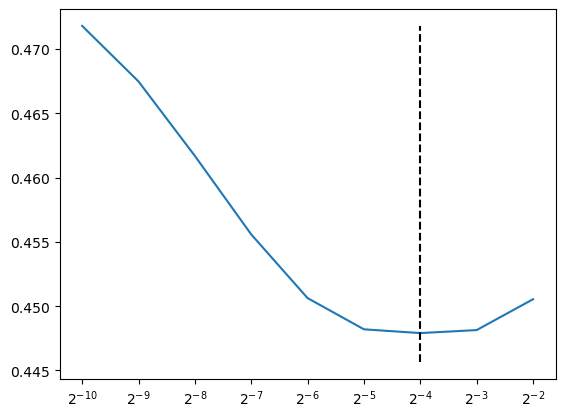

In [314]:
plt.semilogx(learning_rate_vec, weighted_poisson_deviance, base=2)
optimal_index_learning_rate = np.argmin(weighted_poisson_deviance)
print("We get a optimal value weighted Poisson deviance of:", weighted_poisson_deviance[optimal_index_learning_rate])
print("With a value of 'log2(learning_rate)' equal to ", np.log2(learning_rate_vec[optimal_index_learning_rate]))
plt.vlines(learning_rate_vec[optimal_index_learning_rate], ymin = 0.995 * np.min(weighted_poisson_deviance), ymax = np.max(weighted_poisson_deviance), colors = "black", linestyles= 'dashed')

Using the optimal value for learning rate, we now look at number of boosting steps, which is called max_iter. We look at


$$
\log_2\left(\text{max\_iter}\right)  \in  \{0, 1, \ldots, 8, 9 \} 
$$


In [315]:
from sklearn.ensemble import HistGradientBoostingRegressor

max_iter_vec = 2**np.arange(0, 10)

weighted_poisson_deviance = np.zeros(len(max_iter_vec))

for train, test in kf.split(X_train, y_train):
    X_training_data = X_train[train]
    X_test_data = X_train[test]
    
    y_training_data = y_train[train]
    y_test_data = y_train[test]
    
    for i in range(len(max_iter_vec)):
        max_iter = max_iter_vec[i]
        gradient_boosting = HistGradientBoostingRegressor(loss = "poisson", early_stopping= False, max_iter = max_iter, learning_rate= learning_rate_vec[optimal_index_learning_rate])
        gradient_boosting.fit(X_training_data, y_training_data[:, 0], y_training_data[:, 1])
        
        y_pred = gradient_boosting.predict(X_test_data)
        
        weighted_poisson_deviance[i] += mean_poisson_deviance(y_test_data[:, 0], y_pred, sample_weight = y_test_data[:, 1]) / K_fold

We get a optimal value weighted Poisson deviance of: 0.4589258858460912
With a value of 'log2(max_iter)' equal to  7.0


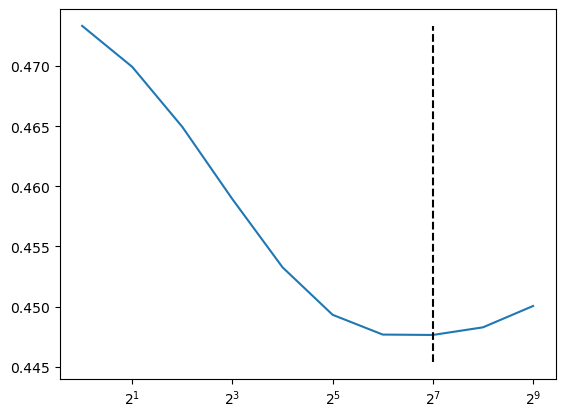

In [316]:
plt.semilogx(max_iter_vec, weighted_poisson_deviance, base=2)
optimal_index_max_iter = np.argmin(weighted_poisson_deviance)
print("We get a optimal value weighted Poisson deviance of:", weighted_poisson_deviance[optimal_index_features])
print("With a value of 'log2(max_iter)' equal to ", np.log2(max_iter_vec[optimal_index_max_iter]))
plt.vlines(max_iter_vec[optimal_index_max_iter], ymin = 0.995 * np.min(weighted_poisson_deviance), ymax = np.max(weighted_poisson_deviance), colors = "black", linestyles= 'dashed')

In [317]:
# Fitting the optimal random forrest
gradient_boosting = HistGradientBoostingRegressor(loss = "poisson", early_stopping= False, max_iter = max_iter_vec[optimal_index_max_iter], 
                                               learning_rate= learning_rate_vec[optimal_index_learning_rate])
gradient_boosting.fit(X_train, y_train[:, 0], sample_weight= y_train[:, 1])

HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.0625,
                              loss='poisson', max_iter=128)

In [318]:
# Loss on training data
y_predict_train = gradient_boosting.predict(X_train)
MAE_train = mean_absolute_error(y_true= y_train[:, 0], y_pred= y_predict_train, sample_weight= y_train[:, 1])
MSE_train = mean_squared_error(y_true= y_train[:, 0], y_pred= y_predict_train, sample_weight=  y_train[:, 1])
MPD_train = mean_poisson_deviance(y_true= y_train[:, 0], y_pred= y_predict_train,sample_weight=  y_train[:, 1])

# Loss on test data
y_predict_test = gradient_boosting.predict(X_test)
MAE_test = mean_absolute_error(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])
MSE_test = mean_squared_error(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])
MPD_test = mean_poisson_deviance(y_true= y_test[:, 0], y_pred= y_predict_test, sample_weight= y_test[:, 1])


# Report metrics
print('Mean Absolute Error for training data: ', MAE_train)
print('Mean Squared Error for training data: ', MSE_train)
print('Mean Poisson Deviance for training data: ', MPD_train)

print('Mean Absolute Error for test data: ', MAE_test)
print('Mean Squared Error for test data: ', MSE_test)
print('Mean Poisson Deviance for test data: ', MPD_test)

Mean Absolute Error for training data:  0.1353761528918296
Mean Squared Error for training data:  0.23518823557938762
Mean Poisson Deviance for training data:  0.4375285222791467
Mean Absolute Error for test data:  0.13627272065918947
Mean Squared Error for test data:  0.22802382979565852
Mean Poisson Deviance for test data:  0.444637802305947


We get the lowest losses using gradient boosted trees from HistGradientBoostingRegressor. We also get a somewhat lower value for the training data compared to the test data. 